In [25]:
!pip install ultralytics pyyaml
!pip install albumentations
!pip uninstall torch torchvision torchaudio -y
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Found existing installation: torch 2.7.0+cu128
Uninstalling torch-2.7.0+cu128:
  Successfully uninstalled torch-2.7.0+cu128
Found existing installation: torchvision 0.22.0
Uninstalling torchvision-0.22.0:
  Successfully uninstalled torchvision-0.22.0
Found existing installation: torchaudio 2.7.0+cu128
Uninstalling torchaudio-2.7.0+cu128:
  Successfully uninstalled torchaudio-2.7.0+cu128


You can safely remove it manually.
You can safely remove it manually.


Looking in indexes: https://download.pytorch.org/whl/cu118
   ---------------------------------------- 0.0/2.9 GB ? eta -:--:--
   ---------------------------------------- 0.0/2.9 GB 5.6 MB/s eta 0:08:42
   ---------------------------------------- 0.0/2.9 GB 5.6 MB/s eta 0:08:40
   ---------------------------------------- 0.0/2.9 GB 5.8 MB/s eta 0:08:24
   ---------------------------------------- 0.0/2.9 GB 5.5 MB/s eta 0:08:52
   ---------------------------------------- 0.0/2.9 GB 5.3 MB/s eta 0:09:07
   ---------------------------------------- 0.0/2.9 GB 5.4 MB/s eta 0:08:54
   ---------------------------------------- 0.0/2.9 GB 5.5 MB/s eta 0:08:52
   ---------------------------------------- 0.0/2.9 GB 5.5 MB/s eta 0:08:50
   ---------------------------------------- 0.0/2.9 GB 5.0 MB/s eta 0:09:35
   ---------------------------------------- 0.0/2.9 GB 4.9 MB/s eta 0:09:51
   ---------------------------------------- 0.0/2.9 GB 4.8 MB/s eta 0:10:01
   ---------------------------------

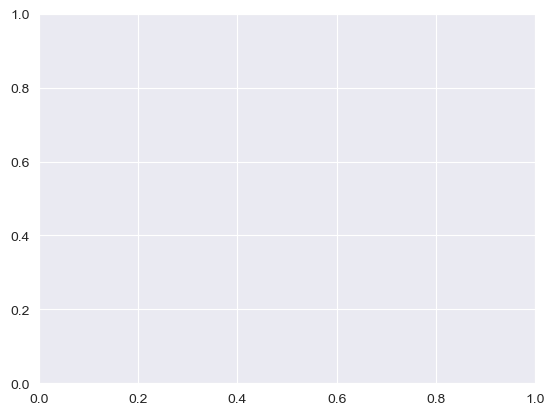

In [1]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots()

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.patches as patches
import seaborn as sns
import warnings
from PIL import Image
import yaml

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
from torch import nn
import torchvision
from torchvision.ops import box_iou
from torch.utils.data import Dataset
from torchvision import transforms as T, models, datasets
from torch.utils.data import DataLoader
from torchvision.transforms import v2
from ultralytics import YOLO

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [3]:
warnings.filterwarnings("ignore")

In [4]:
training_data = datasets.Kitti(
    root='data',
    train=True,
    download=True,
    transform=v2.ToTensor(),
)

test_data = datasets.Kitti(
    root='data',
    train=False,
    download=True,
    transform=v2.ToTensor(),
)

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
KITTI_DIR = "data/Kitti/raw"
IMAGE_DIR = os.path.join(KITTI_DIR, "training/image_2")
LABEL_DIR = os.path.join(KITTI_DIR, "training/label_2")
OUTPUT_IMAGE_DIR = "data/kitti_for_yolo/images"
OUTPUT_LABEL_DIR = "data/kitti_for_yolo/labels"

# Классы KITTI, которые будем использовать
CLASSES = ['Car', 'Cyclist', 'DontCare', 'Misc', 'Pedestrian', 'Person_sitting', 'Tram', 'Truck', 'Van']
CLASS_TO_IDX = {cls: idx for idx, cls in enumerate(CLASSES)}

In [6]:
def kitti_to_yolo(kitti_label_path, output_dir, img_width, img_height):
    """
    Конвертирует аннотации KITTI в формат YOLO:
    <class_id> <x_center> <y_center> <width> <height> (нормализованные)
    """
    os.makedirs(output_dir, exist_ok=True)

    with open(kitti_label_path, 'r') as f:
        lines = f.readlines()

    classes = {'Car': 0, 'Cyclist': 1, 'DontCare': 2, 'Misc': 3, 'Pedestrian': 4,
                'Person_sitting': 5, 'Tram': 6, 'Truck': 7, 'Van': 8}
    labels = []
    yolo_lines = []
    for line in lines:
        parts = line.strip().split()
        class_name = parts[0]

        # Классы KITTI: 'Car', 'Pedestrian', 'Cyclist' → приводим к стандарту YOLO
        class_id = CLASS_TO_IDX[class_name]
        labels.append(class_id)

        x_min, y_min, x_max, y_max = map(float, parts[4:8])

        # Нормализация координат
        x_center = ((x_min + x_max) / 2) / img_width
        y_center = ((y_min + y_max) / 2) / img_height
        width = (x_max - x_min) / img_width
        height = (y_max - y_min) / img_height

        yolo_lines.append(f"{class_id} {x_center} {y_center} {width} {height}\n")

    # Сохраняем в файл
    output_path = os.path.join(output_dir, os.path.basename(kitti_label_path))
    with open(output_path, 'w') as f:
        f.writelines(yolo_lines)

    return labels

In [15]:
img_names = os.listdir(IMAGE_DIR)
label_names = os.listdir(LABEL_DIR)
label_distribution = []

for i in range(7481):
    img = Image.open(os.path.join(IMAGE_DIR, img_names[i]))
    img_width, img_height = img.size
    label_distribution.extend(kitti_to_yolo(os.path.join(LABEL_DIR, label_names[i]), OUTPUT_LABEL_DIR, img_width, img_height))

In [16]:
torch.save(label_distribution, 'models/YOLO/data/label_distribution.pth')

In [7]:
label_distribution = torch.load('models/YOLO/data/label_distribution.pth', weights_only=True)

In [8]:
label_distribution = np.array(label_distribution)
len(label_distribution[label_distribution == 5])

222

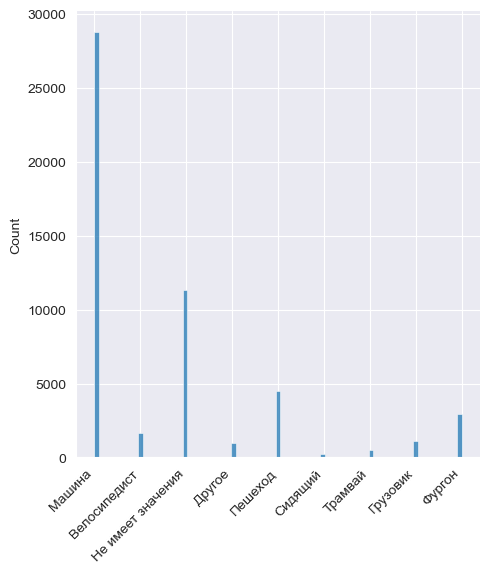

In [14]:
sns.displot(np.array(label_distribution))

plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6, 7, 8], labels=['Машина', 'Велосипедист', 'Не имеет значения', 'Другое', 'Пешеход', 'Сидящий', 'Трамвай', 'Грузовик', 'Фургон'])
plt.xticks(rotation=45, ha='right')

plt.show()

In [7]:
class KittiDataset(Dataset):
    def __init__(self, img_dir, label_dir, transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        self.img_names = os.listdir(img_dir)

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_names[idx])
        label_path = os.path.join(self.label_dir, self.img_names[idx].replace(".png", ".txt"))

        # Загрузка изображения
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Загрузка аннотаций
        labels = []
        boxes = []
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f.readlines():
                    class_id, x_center, y_center, width, height = map(float, line.split())
                    boxes.append([x_center, y_center, width, height])
                    labels.append(int(class_id))

        # Применение трансформаций
        if self.transform:
            transformed = self.transform(
                image=image,
                bboxes=boxes,
                class_labels=labels
            )
            image = transformed['image']
            boxes = transformed['bboxes']
            labels = transformed['class_labels']

        # Подготовка целевых тензоров для YOLO
        targets = torch.zeros((len(boxes), 5), dtype=torch.float32)
        for i, (box, label) in enumerate(zip(boxes, labels)):
            targets[i, 0] = label
            targets[i, 1:] = torch.tensor(box)

        return image, targets

In [21]:
def create_train_test_loaders(test_size=0.2):
    # Разделение на train/test
    all_images = [f for f in os.listdir(IMAGE_DIR) if f.endswith('.png')]
    train_images, test_images = train_test_split(all_images, test_size=test_size, random_state=42)

    # Создаем папки для train/test
    os.makedirs(os.path.join(OUTPUT_LABEL_DIR, "train"), exist_ok=True)
    os.makedirs(os.path.join(OUTPUT_LABEL_DIR, "val"), exist_ok=True)
    os.makedirs(os.path.join(OUTPUT_IMAGE_DIR, "train"), exist_ok=True)
    os.makedirs(os.path.join(OUTPUT_IMAGE_DIR, "val"), exist_ok=True)

    # Копируем аннотации в соответствующие папки
    for img in train_images:
        label = img.replace('.png', '.txt')
        os.rename(
            os.path.join(OUTPUT_LABEL_DIR, label),
            os.path.join(OUTPUT_LABEL_DIR, "train", label))

    for img in test_images:
        label = img.replace('.png', '.txt')
        os.rename(
            os.path.join(OUTPUT_LABEL_DIR, label),
            os.path.join(OUTPUT_LABEL_DIR, "val", label))

    for img in train_images:
        os.rename(
            os.path.join(OUTPUT_IMAGE_DIR, img),
            os.path.join(OUTPUT_IMAGE_DIR, "train", img))

    for img in test_images:
        os.rename(
            os.path.join(OUTPUT_IMAGE_DIR, img),
            os.path.join(OUTPUT_IMAGE_DIR, "val", img))

create_train_test_loaders()

In [8]:
def collate_fn(batch):
    """Обработка батча с разным количеством объектов на изображении"""
    images, targets = zip(*batch)
    images = [torch.from_numpy(img) if isinstance(img, np.ndarray) else img for img in images]
    images = torch.stack([img.float() for img in images])
    return images, targets

batch_size = 8
img_size = 640

# Трансформации
train_transform = A.Compose([
    A.Resize(img_size, img_size),
    A.HorizontalFlip(p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),
    A.Blur(blur_limit=3, p=0.1),
    A.Normalize(mean=[0, 0, 0], std=[1, 1, 1]),
    ToTensorV2()
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

test_transform = A.Compose([
    A.Resize(img_size, img_size),
    A.Normalize(mean=[0, 0, 0], std=[1, 1, 1]),
    ToTensorV2()
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))


# Создание датасетов
train_dataset = KittiDataset(
    img_dir=os.path.join(OUTPUT_IMAGE_DIR, "train"),
    label_dir=os.path.join(OUTPUT_LABEL_DIR, "train"),
    transform=train_transform)

test_dataset = KittiDataset(
    img_dir=os.path.join(OUTPUT_IMAGE_DIR, "val"),
    label_dir=os.path.join(OUTPUT_LABEL_DIR, "val"),
    transform=test_transform)


# Создание DataLoader'ов
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=0)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=0)

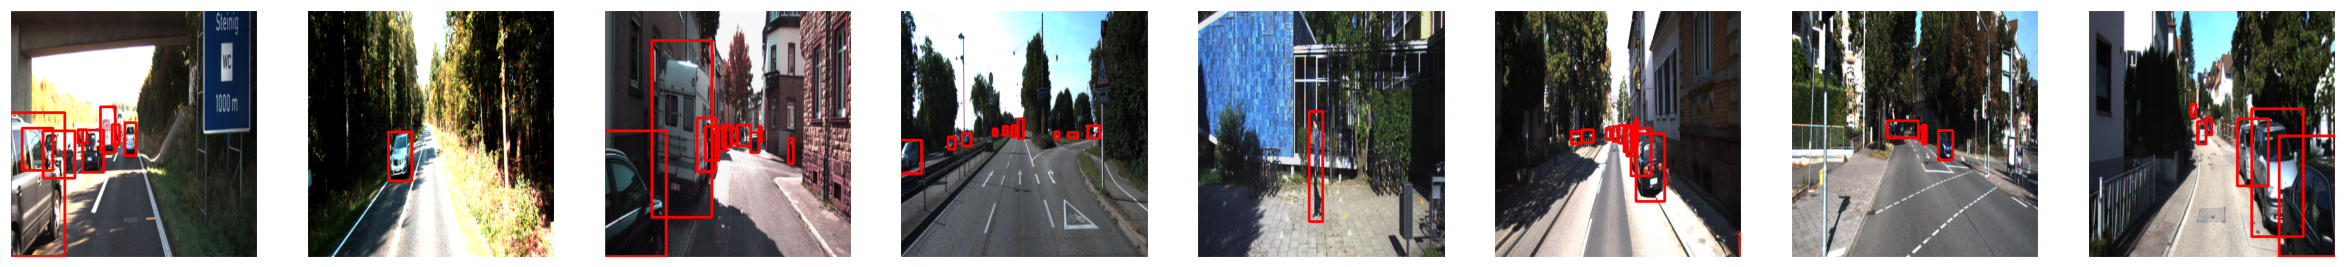

In [9]:
# Визуализация одного батча
images, targets = next(iter(train_loader))
fig, axes = plt.subplots(ncols=len(images), squeeze=False, figsize=(30, 5))
for i in range(len(images)):
    img = images[i].permute(1, 2, 0).numpy()
    img = (img * 255).astype(np.uint8)
    boxes = targets[i][:, 1:].numpy()
    img_ = img.copy()

    # Денормализация координат для отображения
    h, w = img.shape[:2]
    boxes[:, [0, 2]] *= w
    boxes[:, [1, 3]] *= h

    # Рисуем боксы
    for box in boxes:
        x, y, w, h = box
        x1 = int((x - w/2))
        y1 = int((y - h/2))
        x2 = int((x + w/2))
        y2 = int((y + h/2))
        cv2.rectangle(img_, (x1, y1), (x2, y2), (255, 0, 0), 5)
    axes[0, i].imshow(img_)
    axes[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [18]:
model = YOLO("yolov8n.pt")

In [20]:
results = model.train(
    data='data.yaml',
    epochs=10,
    batch=8,
    imgsz=640,
    device='0',  # 'cpu' или '0' для GPU
    name='yolov8_kitti',
    optimizer='Adam',
    lr0=0.00001,
    augment=True,  # автоматические аугментации
    pretrained=True
)

# Сохранение лучшей модели
best_model = YOLO('models/YOLO/yolov8_kitti/weights/best.pt')

New https://pypi.org/project/ultralytics/8.3.143 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.140  Python-3.12.7 torch-2.7.0+cu118 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=1e-05, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8_kitti8, nbs=64, nms=False, opset=None, optimize=False

train: Scanning C:\Users\1\Documents\Stud BMSTU\6 semestr\NIRS\RCNN_project\data\Kitti_for_yolo\labels\train.cache... 5984 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5984/5984 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access  (ping: 0.10.1 ms, read: 1464.1230.3 MB/s, size: 788.1 KB)


val: Scanning C:\Users\1\Documents\Stud BMSTU\6 semestr\NIRS\RCNN_project\data\Kitti_for_yolo\labels\val.cache... 1497 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1497/1497 [00:00<?, ?it/s]


Plotting labels to runs\detect\yolov8_kitti8\labels.jpg... 
optimizer: Adam(lr=1e-05, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\yolov8_kitti8
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      1.43G      1.064     0.6994     0.9813         45        640: 100%|██████████| 748/748 [00:42<00:00, 17.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:04<00:00, 19.33it/s]


                   all       1497      10577      0.719      0.659      0.713       0.46

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      1.43G      1.012     0.6512     0.9646         48        640: 100%|██████████| 748/748 [00:39<00:00, 19.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:04<00:00, 19.58it/s]

                   all       1497      10577      0.754      0.663      0.726      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      1.43G     0.9932     0.6349     0.9567         41        640: 100%|██████████| 748/748 [00:38<00:00, 19.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:04<00:00, 19.02it/s]

                   all       1497      10577      0.743      0.677      0.729       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      1.43G     0.9822     0.6258     0.9554         74        640: 100%|██████████| 748/748 [00:38<00:00, 19.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:04<00:00, 19.68it/s]


                   all       1497      10577      0.752      0.672      0.729      0.483

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      1.43G     0.9784     0.6204     0.9539         54        640: 100%|██████████| 748/748 [00:38<00:00, 19.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:04<00:00, 19.33it/s]


                   all       1497      10577      0.745      0.671       0.73      0.483

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      1.43G     0.9808      0.623     0.9533         56        640: 100%|██████████| 748/748 [00:38<00:00, 19.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:04<00:00, 19.54it/s]


                   all       1497      10577      0.743      0.676      0.734      0.485

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      1.43G      0.982     0.6215      0.952         52        640: 100%|██████████| 748/748 [00:38<00:00, 19.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:04<00:00, 19.43it/s]

                   all       1497      10577      0.743      0.675       0.73      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      1.43G     0.9811     0.6239     0.9537         66        640: 100%|██████████| 748/748 [00:38<00:00, 19.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:05<00:00, 18.28it/s]

                   all       1497      10577      0.735      0.677      0.734      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      1.43G     0.9804     0.6225     0.9534         56        640: 100%|██████████| 748/748 [00:39<00:00, 19.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:04<00:00, 19.08it/s]


                   all       1497      10577      0.741      0.674      0.731      0.484

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      1.43G     0.9834      0.626     0.9537         48        640: 100%|██████████| 748/748 [00:38<00:00, 19.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:04<00:00, 19.11it/s]


                   all       1497      10577      0.747      0.672       0.73      0.484

10 epochs completed in 0.127 hours.
Optimizer stripped from runs\detect\yolov8_kitti8\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\yolov8_kitti8\weights\best.pt, 6.2MB

Validating runs\detect\yolov8_kitti8\weights\best.pt...
Ultralytics 8.3.140  Python-3.12.7 torch-2.7.0+cu118 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 8188MiB)
Model summary (fused): 72 layers, 3,007,403 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:07<00:00, 11.76it/s]


                   all       1497      10577      0.799      0.628      0.729      0.478
                   Car       1338       5889      0.894      0.851       0.93       0.71
               Cyclist        222        308      0.798      0.627       0.74      0.438
              DontCare       1110       2346      0.687     0.0281      0.191     0.0625
                  Misc        156        187      0.746      0.642       0.73      0.513
            Pedestrian        359        916      0.874      0.552      0.718      0.388
        Person_sitting         20         39      0.717      0.456      0.564      0.253
                  Tram         62         95      0.715      0.844      0.872      0.561
                 Truck        220        227      0.885      0.885       0.94      0.729
                   Van        427        570      0.873       0.77      0.873      0.644
Speed: 0.1ms preprocess, 1.6ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs\detect

FileNotFoundError: [Errno 2] No such file or directory: 'runs\\detect\\yolov8_kitti\\weights\\best.pt'

In [227]:
model = YOLO('models/YOLO/yolov8_kitti/weights/best.pt')
model = model.to('cuda').half()

In [440]:
results = model.predict(
    source='data/Kitti_for_yolo/images/val/000079.png',
    conf=0.5,  # порог уверенности
    iou=0.5,  # порог IoU для NMS
    #save=True,
    show_labels=True
)
results = model('data/Kitti_for_yolo/images/val/000079.png')
# Визуализация результатов
for i in range(len(results)):
    results[i].names = {0: 'Машина', 1: 'Велосипедист', 2: 'Не имеет значения', 3: 'Другое', 4: 'Пешеход', 5: 'Сидящая персона', 6: 'Трамвай', 7: 'Грузовик', 8: 'Фургон'}
    #results[i].show()  # отобразить изображение с предсказаниями
    print(f"FPS: {1 / results[i].speed['inference']*1000:.2f}")
    #result.save('result.jpg')  # сохранить результат


image 1/1 C:\Users\1\Documents\Stud BMSTU\6 semestr\NIRS\RCNN_project\data\Kitti_for_yolo\images\val\000079.png: 224x640 4 Cars, 1 DontCare, 1 Tram, 2 Trucks, 10.8ms
Speed: 2.6ms preprocess, 10.8ms inference, 1.8ms postprocess per image at shape (1, 3, 224, 640)
{'preprocess': 2.5754000525921583, 'inference': 10.786099941469729, 'postprocess': 1.7997000832110643}
FPS: 92.71


In [11]:
def calculate_iou(box1, box2):
    """Вычисляет IoU между двумя боксами в формате [x1,y1,x2,y2]"""
    box1 = torch.tensor([box1], dtype=torch.float32)
    box2 = torch.tensor([box2], dtype=torch.float32)
    return box_iou(box1, box2).item()

def evaluate_model(model, dataset_yaml, conf_thresholds=np.linspace(0.00, 0.95, 11)):
    """Основная функция оценки модели"""
    # Инициализация предсказателя
    temp_result = model.predict(data=dataset_yaml, save=False)
    predictor = model.predictor

    # Получение путей к изображениям и меткам
    with open(dataset_yaml) as f:
        data = yaml.safe_load(f)

    val_image_dir = data['val']
    val_label_dir = val_image_dir.replace('images', 'labels')
    image_files = sorted([f for f in os.listdir(val_image_dir) if f.endswith(('.jpg', '.png'))])

    # Сбор всех данных для метрик
    all_metrics = {
        'scores': [],
        'labels': [],
        'pds': [],
        'pfas': [],
        'precision': [],
        'conf_thresholds': conf_thresholds
    }
    # Проход по всему датасету
    for img_file in image_files:
        img_path = os.path.join(val_image_dir, img_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Загрузка истинных меток
        label_path = os.path.join(val_label_dir, img_file.replace('.jpg', '.txt').replace('.png', '.txt'))
        gt_boxes = []
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f.readlines():
                    parts = line.strip().split()
                    if len(parts) == 5:  # Проверка формата YOLO (class, x_center, y_center, w, h)
                        class_id, x_center, y_center, width, height = map(float, parts)
                        # Конвертация YOLO -> XYXY
                        x1 = (x_center - width/2) * img.shape[1]
                        y1 = (y_center - height/2) * img.shape[0]
                        x2 = (x_center + width/2) * img.shape[1]
                        y2 = (y_center + height/2) * img.shape[0]
                        gt_boxes.append([x1, y1, x2, y2])

        # Получение предсказаний
        results = model.predict(img, conf=0.01, verbose=False)  # Низкий порог для полной кривой
        if len(results) == 0:
            continue

        pred = results[0]
        pred_boxes = pred.boxes.xyxy.cpu().numpy()
        pred_scores = pred.boxes.conf.cpu().numpy()

        # Сопоставление предсказаний с истинными метками
        matched_gt = set()
        for i, p_box in enumerate(pred_boxes):
            max_iou = 0
            best_match = -1
            for j, g_box in enumerate(gt_boxes):
                iou = calculate_iou(p_box, g_box)
                if iou > max_iou:
                    max_iou = iou
                    best_match = j

            # Сохраняем результаты для Precision-Recall
            if max_iou >= 0.5 and best_match not in matched_gt:
                all_metrics['labels'].append(1)  # True Positive
                matched_gt.add(best_match)
            else:
                all_metrics['labels'].append(0)  # False Positive
            all_metrics['scores'].append(pred_scores[i])

    # Расчет Precision-Recall
    precision, recall, thresholds = precision_recall_curve(all_metrics['labels'], all_metrics['scores'])
    #print(_)
    all_metrics['pr_curve'] = (precision, recall, thresholds)
    all_metrics['ap'] = auc(recall, precision)

    # Расчет Pd и Pfa для разных порогов
    k = 0
    for conf in conf_thresholds:
        print(k)
        k += 1
        tp, fp, fn = 0, 0, 0
        for img_file in image_files:
            img_path = os.path.join(val_image_dir, img_file)
            results = model.predict(img_path, conf=conf, verbose=False)

            # Получаем истинные метки
            label_path = os.path.join(val_label_dir, img_file.replace('.jpg', '.txt').replace('.png', '.txt'))
            gt_boxes = []
            if os.path.exists(label_path):
                with open(label_path, 'r') as f:
                    for line in f.readlines():
                        parts = line.strip().split()
                        if len(parts) == 5:
                            class_id, x_center, y_center, width, height = map(float, parts)
                            x1 = (x_center - width/2) * img.shape[1]
                            y1 = (y_center - height/2) * img.shape[0]
                            x2 = (x_center + width/2) * img.shape[1]
                            y2 = (y_center + height/2) * img.shape[0]
                            gt_boxes.append([x1, y1, x2, y2])

            # Обработка предсказаний
            if len(results) > 0:
                pred = results[0]
                pred_boxes = pred.boxes.xyxy.cpu().numpy()

                # Сопоставление
                matched = set()
                for p_box in pred_boxes:
                    max_iou = 0
                    best_match = -1
                    for j, g_box in enumerate(gt_boxes):
                        iou = calculate_iou(p_box, g_box)
                        if iou > max_iou:
                            max_iou = iou
                            best_match = j

                    if max_iou >= 0.5 and best_match not in matched:
                        tp += 1
                        matched.add(best_match)
                    else:
                        fp += 1

                fn += len(gt_boxes) - len(matched)

        pd = tp / (tp + fn) if (tp + fn) > 0 else 0
        pfa = fp / (fp + tp) if (fp + tp) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        all_metrics['pds'].append(pd)
        all_metrics['pfas'].append(pfa)
        all_metrics['precision'].append(precision)

    return all_metrics


# Основной код
if __name__ == "__main__":
    # 1. Загрузка модели
    model = YOLO('models/YOLO/yolov8_kitti/weights/best.pt')
    model = model.to(device)

    # 2. Оценка стандартных метрик через val()
    metrics = model.val(data='data.yaml', split='val')
    print(f"mAP при IOU = 0.5: {metrics.box.map50:.3f}")  # mAP при IoU 0.5
    print(f"Precision: {metrics.box.p}")         # Precision
    print(f"Recall: {metrics.box.r}")            # Recall
    print(f"F1-score: {metrics.box.f1}")         # F1-score

    # 3. Детальная оценка с расчетом Pd и Pfa
    detailed_metrics = evaluate_model(model, 'data.yaml')

    # 4. Сохранение результатов
    with open('kitti_metrics_report.txt', 'w') as f:
        f.write(f"mAP при IOU = 0: {metrics.box.map50:.3f}\n")
        f.write(f"Precision: {metrics.box.p}\n")
        f.write(f"Recall: {metrics.box.r}\n")
        f.write(f"F1-score: {metrics.box.f1}\n")
        f.write(f"Average Precision: {detailed_metrics['ap']:.3f}\n")
        f.write(f"Max Pd: {max(detailed_metrics['pds']):.3f}\n")
        f.write(f"Min Pfa: {min([pfa for pfa in detailed_metrics['pfas'] if pfa > 0]):.3f}\n")

Model summary (fused): 72 layers, 3,007,403 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 3650.11772.7 MB/s, size: 795.0 KB)


val: Scanning C:\Users\1\Documents\Stud BMSTU\6 semestr\NIRS\RCNN_project\data\Kitti_for_yolo\labels\val.cache... 1497 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1497/1497 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:07<00:00, 12.49it/s]


                   all       1497      10577      0.739      0.674      0.732      0.485
                   Car       1338       5889      0.861      0.895       0.94      0.728
               Cyclist        222        308      0.719      0.711      0.769      0.455
              DontCare       1110       2346      0.535      0.112      0.214     0.0695
                  Misc        156        187      0.727      0.679      0.742      0.525
            Pedestrian        359        916      0.785      0.645      0.736      0.392
        Person_sitting         20         39      0.546       0.41      0.476      0.232
                  Tram         62         95      0.771      0.895      0.884      0.576
                 Truck        220        227       0.91      0.899      0.942      0.742
                   Van        427        570      0.799      0.825      0.881      0.648
Speed: 0.1ms preprocess, 1.0ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs\detect

In [23]:
def plot_metrics(metrics):
    """Построение графиков метрик"""
    plt.figure(figsize=(22, 5))

    # Precision-Recall кривая
    plt.subplot(141)
    precision, recall, thresholds = metrics['pr_curve']
    plt.plot(recall, precision, 'b-', linewidth=2, label=f'Площадь под кривой (Average Precision) = {metrics["ap"]:.3f}')
    plt.xlabel('Полнота (Recall)')
    plt.ylabel('Точность (Precision)')
    plt.title('Кривая Точность-Полнота')
    plt.legend()
    plt.grid(True)

    # Кривая Pfa по порогам
    plt.subplot(142)
    plt.plot(metrics['conf_thresholds'], metrics['pfas'], 'r-', linewidth=2)
    plt.xlabel('Порог уверенности')
    plt.ylabel('Вероятность ложного срабатывания (Pfa)')
    plt.title('Кривая вероятности ложного срабатывания')
    plt.grid(True)

    # Кривая Pd по порогам
    plt.subplot(143)
    plt.plot(metrics['conf_thresholds'], metrics['pds'], 'g-', linewidth=2)
    plt.xlabel('Порог уверенности')
    plt.ylabel('Вероятность обнаружения (Pd)')
    plt.title('Кривая вероятности обнаружения')
    plt.grid(True)

    # Кривая Pd-Pfa
    plt.subplot(144)
    plt.plot(metrics['pfas'], metrics['pds'], 'b-', linewidth=2)
    plt.xlabel('Вероятность ложного срабатывания (Pfa)')
    plt.ylabel('Вероятность обнаружения (Pd)')
    plt.title('Кривая рабочих характеристик детектора (DET)')
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('kitti_metrics.png')
    plt.show()

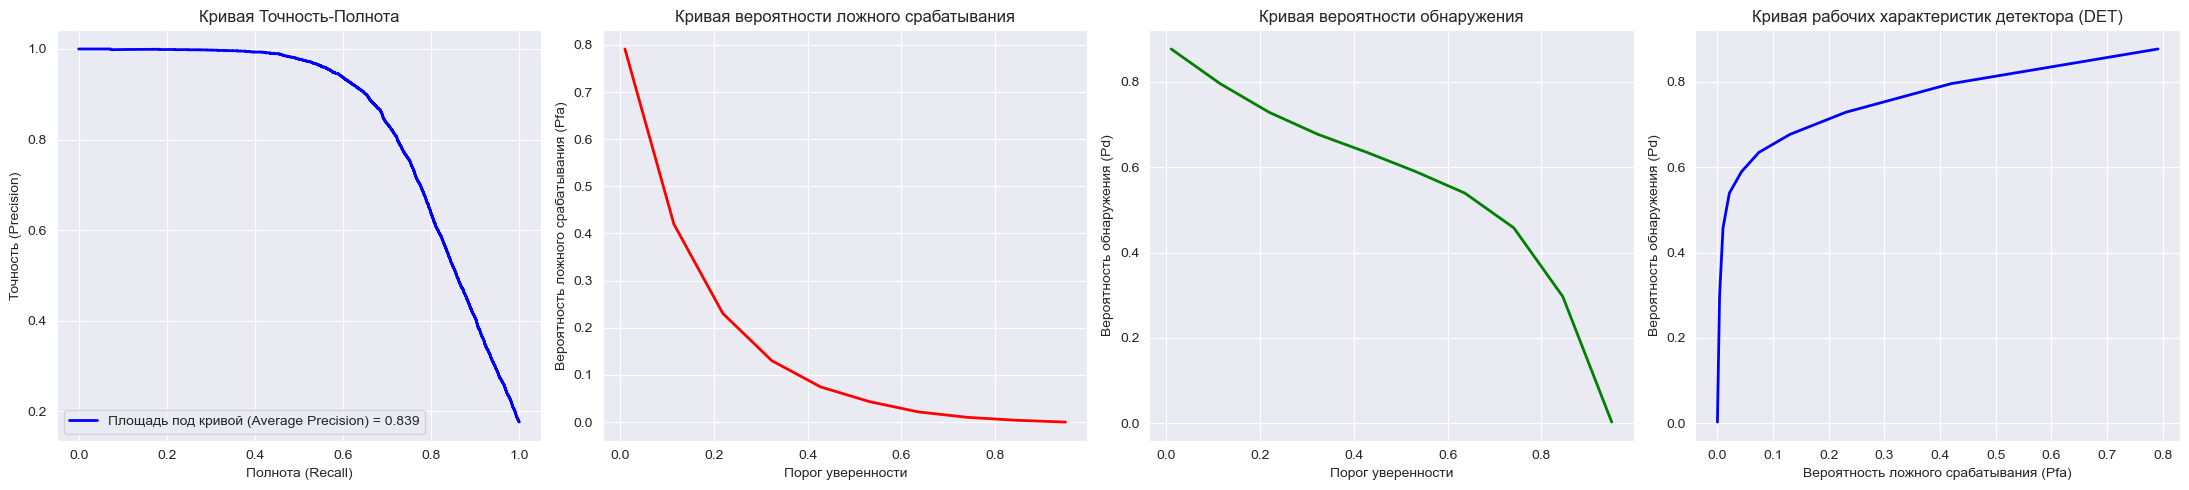

In [24]:
plot_metrics(detailed_metrics)

In [79]:
np.array(detailed_metrics['pds']).round(5)*100

array([       87.7,      79.578,      72.875,      67.694,      63.477,      58.958,      53.938,      45.797,      29.706,       0.303])

In [14]:
np.array(detailed_metrics['pfas']).round(5)*100

array([     97.874,      47.147,       27.13,      16.042,       9.457,       5.764,        3.36,       1.768,       0.878,        0.31,           0])

In [73]:
detailed_metrics['conf_thresholds']

array([       0.01,     0.11444,     0.21889,     0.32333,     0.42778,     0.53222,     0.63667,     0.74111,     0.84556,        0.95])